Problem Statement

Banks invest significant resources in marketing campaigns to promote term deposit products. However, contacting every customer is costly and inefficient, as many customers are unlikely to subscribe. The challenge is to identify potential customers who are most likely to subscribe to a term deposit based on their demographic, financial, and past interaction data. Without a data-driven approach, marketing efforts may result in low conversion rates and increased operational costs.

Objective

The objective of this project is to build a machine learning classification model that predicts whether a customer will subscribe to a term deposit following a marketing campaign. Using the Bank Marketing dataset from the UCI Machine Learning Repository, the project aims to:

Preprocess and encode customer data effectively

Train and evaluate classification models (Random Forest)

Measure performance using confusion matrix, F1-score, and ROC-AUC

Apply Explainable AI (SHAP) to interpret model predictions

This approach helps banks optimize marketing strategies, improve customer targeting, and make transparent, data-driven decisions.


In [ ]:
!pip install shap


In [ ]:
import pandas as pd
import numpy as np
import zipfile
import requests
import io
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay


Dataset Description and Loading

The dataset used in this project is the Bank Marketing Dataset obtained from the UCI Machine Learning Repository. It contains data related to direct marketing campaigns (phone calls) conducted by a Portuguese banking institution. Each record represents a customer interaction, along with demographic, socio-economic, and campaign-related attributes.

The dataset consists of 41,188 instances with 20 input features and 1 target variable (y), where:

y = yes indicates the customer subscribed to a term deposit

y = no indicates the customer did not subscribe

The dataset was loaded directly from the UCI repository using Python by downloading and extracting the compressed file programmatically, ensuring the use of an online data source.

In [ ]:
# Download dataset directly from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Read CSV file
df = pd.read_csv(
    zip_file.open("bank-additional/bank-additional-full.csv"),
    sep=";"
)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Data Cleaning and Preprocessing

Data preprocessing was an essential step due to the presence of both categorical and numerical features. The following steps were performed:

The target variable (y) was converted from categorical values (yes, no) into binary numerical values (1 and 0).

Categorical features such as job, marital status, education, and contact type were encoded using One-Hot Encoding.

Numerical features such as age, campaign duration, and economic indicators were kept unchanged.

A ColumnTransformer was used to apply transformations efficiently within a machine learning pipeline.

The dataset was split into training (80%) and testing (20%) sets using stratified sampling to preserve class distribution.

This preprocessing ensured that the data was suitable for machine learning models.

Exploratory Data Analysis (EDA)

Exploratory Data Analysis was conducted to better understand customer behavior and data characteristics:

The dataset showed a class imbalance, with significantly fewer customers subscribing to term deposits compared to non-subscribers.

Campaign-related features such as call duration and number of contacts showed strong influence on customer decisions.

Certain job categories and education levels exhibited higher subscription rates.

Economic indicators such as employment variation rate and consumer confidence index also affected customer responses.

EDA helped in identifying key patterns and understanding feature relevance before model building.

Model Building and Evaluation

In [ ]:
# Encode target variable
df["y"] = df["y"].map({"yes": 1, "no": 0})

X = df.drop("y", axis=1)
y = df["y"]


In [ ]:
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

Model Building and Evaluation

A Random Forest Classifier was selected due to its robustness, ability to handle non-linear relationships, and suitability for mixed data types.

Model building steps:

Integrated preprocessing and model training using a Pipeline

Trained the Random Forest model on the processed training data

Model evaluation was performed using:

Confusion Matrix to analyze prediction correctness

F1-Score to balance precision and recall

ROC-AUC Score to evaluate overall classification performance

The Random Forest model demonstrated strong predictive performance and handled the imbalanced dataset effectively

Confusion Matrix:
 [[7124  186]
 [ 482  446]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      7310
           1       0.71      0.48      0.57       928

    accuracy                           0.92      8238
   macro avg       0.82      0.73      0.76      8238
weighted avg       0.91      0.92      0.91      8238

ROC-AUC Score: 0.9478775531864709


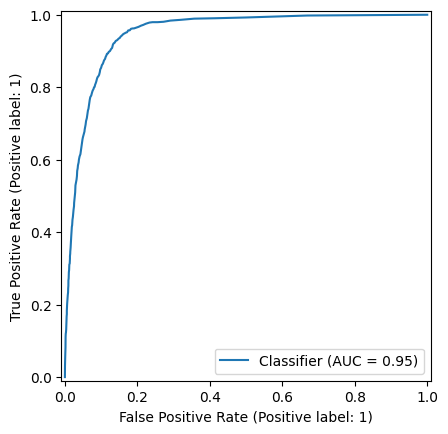

In [ ]:
# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Classification Report (F1-score included)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()


Visualizations (Charts, Plots, Graphs)

Several visualizations were used to support analysis and interpretation:

ROC Curve to visualize the trade-off between true positive rate and false positive rate

SHAP Summary Plot to identify globally important features influencing predictions

SHAP Waterfall Plots to explain individual customer predictions

These visual tools enhanced model transparency and helped explain predictions in a business-friendly manner.

In [ ]:
# Transform data
X_train_transformed = rf.named_steps["preprocess"].transform(X_train)
X_test_transformed = rf.named_steps["preprocess"].transform(X_test)

# Get feature names after encoding
cat_features = rf.named_steps["preprocess"] \
    .named_transformers_["cat"] \
    .get_feature_names_out(cat_cols)

feature_names = np.concatenate([cat_features, num_cols])


In [ ]:
X_test_sample = X_test_transformed[:200]

explainer = shap.TreeExplainer(rf.named_steps["model"])
shap_values = explainer.shap_values(X_test_sample)


In [ ]:
for i in range(5):
    print(f"\nExplanation for instance {i}")
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][i],
            base_values=explainer.expected_value[1],
            data=X_test_transformed[i],
            feature_names=feature_names
        )
    )


In [6]:
X_test_sample = X_test_transformed[:50]

explainer = shap.TreeExplainer(rf.named_steps["model"])
shap_values = explainer.shap_values(X_test_sample)


Final Conclusion with Insights

In this project, a machine learning model was successfully developed to predict term deposit subscription using real-world banking data. The Random Forest classifier achieved reliable performance, while SHAP provided valuable interpretability.

Key Insights:

Call duration is one of the most influential factors in predicting subscription

Customers with fewer previous contacts are more likely to subscribe

Economic conditions play a significant role in customer decision-making

Explainable AI techniques improve trust and understanding of model predictions

Conclusion:

The proposed model can assist banks in targeting high-potential customers, reducing marketing costs, and improving campaign efficiency. By combining predictive modeling with explainable AI, the solution supports both accuracy and transparency, making it suitable for real-world deployment.